### [SETUP] Import Libraries

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor':'dimgrey', 'grid.color':'lightgrey'})

import numpy as np
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch_scatter
from torch_geometric.data import Data
from dgl import DGLGraph
import dgl.function as fn
from functools import partial

# # The PyG built-in GCNConv
# from torch_geometric.nn import GCNConv
from torch_geometric.nn.conv import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, degree

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import scipy.sparse as scsp
from sklearn.cluster import KMeans
import copy
from torch_geometric.nn import GCNConv, GATv2Conv, SAGEConv
from torch_geometric import utils
import os
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity

### Transactions Dataset Overview

In [88]:
print("\nTransaction features: \n")
df_txs_features = pd.read_csv("./elliptic_bitcoin_dataset/elliptic_txs_features.csv")
display(df_txs_features)

print("\nTransaction classes: \n")
df_txs_classes = pd.read_csv("./elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
display(df_txs_classes)

df_txs_nodes = pd.merge(df_txs_classes, df_txs_features, on='txId')
df_removed_txIds = df_txs_nodes[df_txs_nodes["class"] == 3]

# Removing nodes with class = 'unknown'
df_txs_nodes = df_txs_nodes[df_txs_nodes["class"] != 3]

print("\nTransactions (features & classes): \n")
display(df_txs_nodes)

removed_txIds = set(df_removed_txIds['txId'])

print("\nTransaction-Transaction edgelist: \n")
df_txs_edgelist = pd.read_csv("./elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")

#Removing all edges involving nodes with class = 'unknown'
df_txs_edgelist = df_txs_edgelist[~((df_txs_edgelist['txId1'].isin(removed_txIds)) | (df_txs_edgelist['txId2'].isin(removed_txIds)))]
display(df_txs_edgelist)


Transaction features: 



,txId,timestep,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.135803,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,158577750,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156418,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203766,158375402,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163626,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203767,158654197,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163501,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399



Transaction classes: 



,txId,class
0,230425980,3
1,5530458,3
2,232022460,3
3,232438397,0
4,230460314,3
...,...,...
203764,173077460,3
203765,158577750,3
203766,158375402,1
203767,158654197,3



Transactions (features & classes): 



,txId,class,timestep,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165
3,232438397,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
9,232029206,0,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
10,232344069,0,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
11,27553029,0,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
16,3881097,0,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203752,80329479,0,49,-0.159293,-0.037276,1.018602,-0.121970,0.035526,-0.113002,-0.061584,...,1.793987,1.408971,0.231244,-0.388216,-0.098889,1.931078,3.168259,3.707301,-1.390548,-1.214035
203754,158406298,0,49,-0.172962,-0.126566,1.018602,-0.121970,-0.063725,-0.113002,-0.061584,...,-0.577099,0.647874,0.241128,0.241406,10.914916,1.700384,-0.131155,7.914145,-0.120613,-0.119792
203759,158375075,1,49,-0.170412,-0.078164,1.018602,0.028105,-0.043875,0.054722,-0.061584,...,1.709623,1.606604,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203763,147478192,0,49,-0.093732,-0.116160,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792



Transaction-Transaction edgelist: 



,txId1,txId2
5,232344069,27553029
8,3881097,232457116
15,232051089,232470704
26,230473487,7089694
33,231182296,14660781
...,...,...
234338,194020062,47521535
234340,158574502,109383451
234344,158594124,157631640
234347,157631640,21644119


In [134]:
def balance_graph_with_smote_and_edge_generator(df_txs_edgelist, df_txs_nodes, minority_class=1, k_neighbors=5, smote_ratio=1.0, under_sampling_ratio=0.5, edge_generator_weight=1.0):
    # Step 1: Identify minority class nodes
    minority_nodes = df_txs_nodes[df_txs_nodes['class'] == minority_class]

    # Step 2: Find neighbors for each minority class node
    neighbor_dict = {}
    for index, row in df_txs_edgelist.iterrows():
        if row['txId1'] in minority_nodes['txId'].values and row['txId2'] in minority_nodes['txId'].values:
            if row['txId1'] not in neighbor_dict:
                neighbor_dict[row['txId1']] = []
            neighbor_dict[row['txId1']].append(row['txId2'])

            if row['txId2'] not in neighbor_dict:
                neighbor_dict[row['txId2']] = []
            neighbor_dict[row['txId2']].append(row['txId1'])

    # Step 3: Use SMOTE to generate synthetic nodes
    smote = SMOTE(sampling_strategy=smote_ratio, k_neighbors=k_neighbors)
    rus = RandomUnderSampler(sampling_strategy=under_sampling_ratio)
    pipeline = Pipeline([('under', rus), ('over', smote)])

    # Add majority class to minority class for oversampling
    majority_nodes = df_txs_nodes[df_txs_nodes['class'] != minority_class]
    minority_features = minority_nodes.drop(columns=['class'])
    majority_features = majority_nodes.drop(columns=['class'])

    synthetic_features, synthetic_classes = pipeline.fit_resample(pd.concat([minority_features, majority_features]), pd.concat([minority_nodes['class'], majority_nodes['class']]))

    # Add synthetic nodes to the original dataframe
    synthetic_nodes = pd.DataFrame(synthetic_features, columns=minority_features.columns)
    synthetic_nodes['class'] = synthetic_classes  # Assign class values to synthetic nodes
    df_txs_nodes = pd.concat([df_txs_nodes, synthetic_nodes], ignore_index=True)

    # Step 4: Generate synthetic edges using an edge generator
    real_nodes = df_txs_nodes.dropna(subset=['class'])
    real_features = real_nodes.drop(columns=['class'])

    # Assuming h1_v and h1_u are the node representations
    h1_synthetic = synthetic_nodes.drop(columns=['class'])
    h1_real = real_nodes.drop(columns=['class'])

    # Weighted inner product for edge generation
    S = np.random.rand(h1_real.shape[1], h1_synthetic.shape[1])  # Initialize S with random values
    edge_weights = cosine_similarity(h1_real.values @ S.T, h1_synthetic.values)

    # Apply a sigmoid activation function to mimic the edge generator in your description
    edge_weights = 1 / (1 + np.exp(-edge_weights))

    # Adjust the weights according to the specified weight parameter
    edge_weights *= edge_generator_weight

    # Create a dataframe for synthetic edges
    synthetic_edges = pd.DataFrame(columns=['txId1', 'txId2', 'edge_weight'])
    for i, minority_node in enumerate(minority_nodes['txId']):
        if minority_node in neighbor_dict:
            neighbors = neighbor_dict[minority_node]
            for j, neighbor in enumerate(neighbors):
                if neighbor not in synthetic_nodes['txId'].values:
                    synthetic_nodes = synthetic_nodes.append({'txId': neighbor}, ignore_index=True)
                    synthetic_edges = synthetic_edges.append({'txId1': minority_node, 'txId2': neighbor, 'edge_weight': edge_weights[i, j]}, ignore_index=True)

    # Add synthetic edges to the original dataframe
    df_txs_edgelist = pd.concat([df_txs_edgelist, synthetic_edges], ignore_index=True)

    return df_txs_edgelist, df_txs_nodes

In [135]:
df_txs_edgelist_synthetic = df_txs_edgelist.copy()
df_txs_nodes_synthetic = df_txs_nodes.copy()

df_txs_edgelist_synthetic, df_txs_nodes_synthetic = balance_graph_with_smote_and_edge_generator(df_txs_edgelist_synthetic, df_txs_nodes_synthetic)
display(df_txs_nodes_synthetic)
display(df_txs_edgelist_synthetic)

/var/folders/br/9fqjdr8562100jwl_tm_xbb00000gn/T/ipykernel_7582/3113429832.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  synthetic_nodes['class'] = synthetic_classes  # Assign class values to synthetic nodes


,txId,class,timestep,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165
0,232438397,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,232029206,0,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,232344069,0,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,27553029,0,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,3881097,0,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64739,339094217,1,13,-0.172312,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,...,-0.577099,0.168508,0.241128,0.241406,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
64740,245175118,1,3,-0.162157,-0.035661,-1.201369,0.003774,-0.043875,0.027529,-0.061584,...,-0.425607,-0.363862,0.653396,0.653593,-0.021308,-0.087490,-0.115451,-0.112077,-0.674824,-0.674300
64741,355127380,1,32,-0.171854,-0.132459,0.672835,-0.121970,-0.063725,-0.113002,-0.061584,...,-0.577099,-0.028173,0.241128,0.241406,-0.025892,-0.094738,-0.131155,-0.130000,-0.120613,-0.119792
64742,339057951,1,13,-0.171413,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,...,-0.577099,0.086952,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792


,txId1,txId2,edge_weight
0,232344069,27553029,NaN
1,3881097,232457116,NaN
2,232051089,232470704,NaN
3,230473487,7089694,NaN
4,231182296,14660781,NaN
...,...,...,...
36619,194020062,47521535,NaN
36620,158574502,109383451,NaN
36621,158594124,157631640,NaN
36622,157631640,21644119,NaN


In [120]:
len(df_txs_nodes_synthetic[df_txs_nodes_synthetic['class'] == 1])

13635

### Splitting the Data into Training, Validation, and Test sets 

In [136]:
def random_split_transd(new_nodes, new_edges, train_size, test_size):
    """
    Create and return the training, validation, and test set by randomly splitting
    the node indices to these three sets. Keep edge_index known for all sets.

    Args:
        new_nodes     A dataframe of the node features
        new_edges     A dataframe of the graph's adjacency list
        train_size    The node size proportion in training set
        test_size     The node size proportion in test set

    Returns:
        data          A Data object that stores node features, edge_index, and labels
        dict          A dictionary that stores training, validation, test set node indices
    """
    features =  torch.FloatTensor(new_nodes.iloc[:, 2:].to_numpy())
    labels = new_nodes.iloc[:, 1].to_numpy()
    labels = torch.LongTensor(labels.reshape(len(labels),))
    nodes_id = new_nodes.iloc[:, 0].to_numpy()

    # Create a dictionary that maps nodeId to index in the dataframe.
    id2idx = {}
    for i in range(new_nodes.shape[0]):
        id2idx[new_nodes.iloc[i, 0]] = i

    # Construct edge_index with same node indexing as in features and labels
    edge_idx = np.zeros((2, new_edges.shape[0]), dtype = np.int64)
    for index in range(new_edges.shape[0]):
        node1 = id2idx[new_edges.iloc[index, 0]]
        node2 = id2idx[new_edges.iloc[index, 1]]
        edge_idx[:, index] = [node1, node2]
    edge_index = torch.LongTensor(edge_idx)

    train_index, test_index = train_test_split(np.arange(labels.shape[0]),
                                               test_size = 1 - train_size,
                                               random_state = 42)
    val_index, test_index = train_test_split(test_index,
                                             test_size = test_size / (1 - train_size),
                                             random_state = 42)

    # Construct the training, validation, test set and store
    # in a dictionary, 'data'.
    data = Data(x = features, edge_index = edge_index, y = torch.tensor(labels, dtype=torch.float32))

    return data, {'train': torch.tensor(train_index, dtype=torch.long), 'val': torch.tensor(val_index, dtype=torch.long), 'test': torch.tensor(test_index, dtype=torch.long)}

In [138]:
train_node_size, test_node_size = 0.5930547203848466, 0.29252212009277556

data, split_idx = random_split_transd(df_txs_nodes, df_txs_edgelist, train_size = train_node_size,
                         test_size = test_node_size)

data_smote, split_idx_smote = random_split_transd(df_txs_nodes_synthetic, df_txs_edgelist_synthetic, train_size = train_node_size,
                         test_size = test_node_size)

display(data)
display(data_smote)

/var/folders/br/9fqjdr8562100jwl_tm_xbb00000gn/T/ipykernel_7582/840093698.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = Data(x = features, edge_index = edge_index, y = torch.tensor(labels, dtype=torch.float32))


Data(x=[46564, 166], edge_index=[2, 36624], y=[46564])

Data(x=[64744, 166], edge_index=[2, 36624], y=[64744])

### GNN Models

In [139]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super(GCN, self).__init__()

        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        out = self.gcn2(h, edge_index)
        return out

class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super(GAT, self).__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads, dropout=0.6)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, concat=False, heads=1, dropout=0.6)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        out = self.gat2(h, edge_index)
        return out

def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()*1

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

### Training and Testing Functions

In [140]:
def train_evaluate(model, data, split_idx, criterion, optimizer, rgcn, *args):
    num_epochs = args[0]
    checkpoints_dir = args[1]
    model_filename = args[2]

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = 10e10

    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    model.train()
    for epoch in range(num_epochs+1):
        # Training
        optimizer.zero_grad()

        if rgcn:
            out = model(data.x, data.edge_index, data.edge_attr)
        else:
            out = model(data.x, data.edge_index)

        loss = criterion(out[split_idx['train']], data.y[split_idx['train']].unsqueeze(1))
        acc = accuracy(out[split_idx['train']], data.y[split_idx['train']].unsqueeze(1), prediction_threshold=0.5)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[split_idx['val']], data.y[split_idx['val']].unsqueeze(1))
        val_acc = accuracy(out[split_idx['val']], data.y[split_idx['val']].unsqueeze(1), prediction_threshold=0.5)

        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model for best loss")
                checkpoint = {
                    'state_dict': best_model_wts
                }
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
                best_model_wts = copy.deepcopy(model.state_dict())

    return model

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    preds = ((torch.sigmoid(out) > 0.5).float()*1).squeeze(1)
    return preds

### NN Configurations

In [141]:
class Config:
    seed = 0
    learning_rate = 0.001
    weight_decay = 1e-5
    input_dim = 166
    output_dim = 1
    hidden_size = 128
    num_epochs = 100
    checkpoints_dir = './models/elliptic_gnn'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Using device:", Config.device)

Using device: cpu


### Training GCN

In [168]:
gcn_model = GCN(Config.input_dim, 166, Config.output_dim).to(Config.device)

data_train = data.to(Config.device)

optimizer = torch.optim.Adam(gcn_model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCEWithLogitsLoss()

train_evaluate(gcn_model,
              data_train,
              split_idx,
              criterion,
              optimizer,
              0,
              Config.num_epochs,
              Config.checkpoints_dir,
              'gcn_best_model.pth.tar')

Epoch   0 | Train Loss: 1.144 | Train Acc:  59.38% | Val Loss: 1.14 | Val Acc: 59.50%
Saving model for best loss
Epoch  10 | Train Loss: 0.456 | Train Acc:  87.56% | Val Loss: 0.42 | Val Acc: 87.71%
Saving model for best loss
Epoch  20 | Train Loss: 0.400 | Train Acc:  89.11% | Val Loss: 0.39 | Val Acc: 89.60%
Saving model for best loss
Epoch  30 | Train Loss: 0.358 | Train Acc:  89.05% | Val Loss: 0.35 | Val Acc: 88.95%
Saving model for best loss
Epoch  40 | Train Loss: 0.328 | Train Acc:  89.36% | Val Loss: 0.34 | Val Acc: 89.19%
Saving model for best loss
Epoch  50 | Train Loss: 0.314 | Train Acc:  90.31% | Val Loss: 0.30 | Val Acc: 90.77%
Saving model for best loss
Epoch  60 | Train Loss: 0.292 | Train Acc:  90.77% | Val Loss: 0.28 | Val Acc: 90.84%
Saving model for best loss
Epoch  70 | Train Loss: 0.268 | Train Acc:  91.14% | Val Loss: 0.27 | Val Acc: 91.31%
Saving model for best loss
Epoch  80 | Train Loss: 0.263 | Train Acc:  91.50% | Val Loss: 0.26 | Val Acc: 91.65%
Saving mod

GCN(
  (gcn1): GCNConv(166, 166)
  (gcn2): GCNConv(166, 1)
)

### Testing GCN

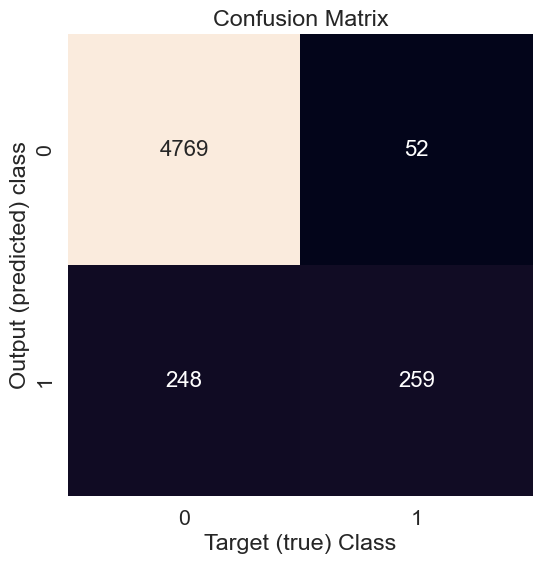

              precision    recall  f1-score   support

       licit       0.95      0.99      0.97      4821
     illicit       0.83      0.51      0.63       507

    accuracy                           0.94      5328
   macro avg       0.89      0.75      0.80      5328
weighted avg       0.94      0.94      0.94      5328

Test data fraud cases, percentage: 6.049482416856325 %


In [169]:
gcn_model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, 'gcn_best_model.pth.tar'))['state_dict'])

y_test_preds = test(gcn_model, data_train)

# confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[split_idx['val']].detach().cpu().numpy(), y_test_preds[split_idx['val']])

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(data_train.y[split_idx['val']].detach().cpu().numpy(),
                            y_test_preds[split_idx['val']],
                            target_names=['licit', 'illicit']))


print(f"Test data fraud cases, percentage: {y_test_preds[split_idx['test']].detach().cpu().numpy().sum() / len(data_train.y[split_idx['test']]) *100} %")

### Training GAT

In [182]:
gat_model = GAT(Config.input_dim, Config.hidden_size, Config.output_dim).to(Config.device)

data_train = data.to(Config.device)

optimizer = torch.optim.Adam(gat_model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCEWithLogitsLoss()

train_evaluate(gat_model,
              data_train,
              split_idx,
              criterion,
              optimizer,
              0,
              Config.num_epochs,
              Config.checkpoints_dir,
              'gat_best_model.pth.tar')

Epoch   0 | Train Loss: 1.724 | Train Acc:  72.00% | Val Loss: 1.74 | Val Acc: 72.52%
Saving model for best loss
Epoch  10 | Train Loss: 0.722 | Train Acc:  88.13% | Val Loss: 0.71 | Val Acc: 88.66%
Saving model for best loss
Epoch  20 | Train Loss: 0.644 | Train Acc:  88.58% | Val Loss: 0.61 | Val Acc: 88.36%
Saving model for best loss
Epoch  30 | Train Loss: 0.624 | Train Acc:  90.02% | Val Loss: 0.59 | Val Acc: 89.92%
Saving model for best loss
Epoch  40 | Train Loss: 0.567 | Train Acc:  89.83% | Val Loss: 0.54 | Val Acc: 89.77%
Saving model for best loss
Epoch  50 | Train Loss: 0.560 | Train Acc:  90.09% | Val Loss: 0.61 | Val Acc: 89.94%
Epoch  60 | Train Loss: 0.528 | Train Acc:  89.90% | Val Loss: 0.54 | Val Acc: 90.35%
Saving model for best loss
Epoch  70 | Train Loss: 0.527 | Train Acc:  90.10% | Val Loss: 0.52 | Val Acc: 90.17%
Saving model for best loss
Epoch  80 | Train Loss: 0.496 | Train Acc:  90.35% | Val Loss: 0.50 | Val Acc: 90.13%
Saving model for best loss
Epoch  90 

GAT(
  (gat1): GATv2Conv(166, 128, heads=8)
  (gat2): GATv2Conv(1024, 1, heads=1)
)

### Testing GAT

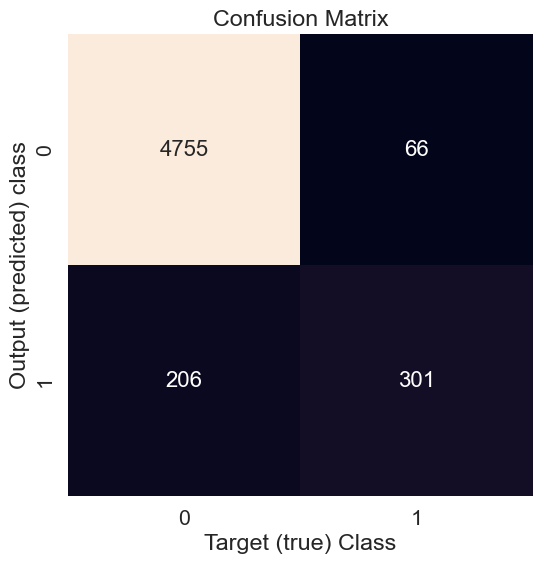

              precision    recall  f1-score   support

       licit       0.96      0.99      0.97      4821
     illicit       0.82      0.59      0.69       507

    accuracy                           0.95      5328
   macro avg       0.89      0.79      0.83      5328
weighted avg       0.95      0.95      0.95      5328

Test data fraud cases, percentage: 7.040599074957786 %


In [183]:
gat_model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, 'gat_best_model.pth.tar'))['state_dict'])

y_test_preds = test(gat_model, data_train)

# confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[split_idx['val']].detach().cpu().numpy(), y_test_preds[split_idx['val']])

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(data_train.y[split_idx['val']].detach().cpu().numpy(),
                            y_test_preds[split_idx['val']],
                            target_names=['licit', 'illicit']))


print(f"Test data fraud cases, percentage: {y_test_preds[split_idx['test']].detach().cpu().numpy().sum() / len(data_train.y[split_idx['test']]) *100} %")

### Training SmGCN

In [186]:
gcn_model = GCN(Config.input_dim, 166, Config.output_dim).to(Config.device)

data_train = data_smote.to(Config.device)

optimizer = torch.optim.Adam(gcn_model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCEWithLogitsLoss()

train_evaluate(gcn_model,
              data_train,
              split_idx_smote,
              criterion,
              optimizer,
              0,
              Config.num_epochs,
              Config.checkpoints_dir,
              'smgcn_best_model.pth.tar')

Epoch   0 | Train Loss: 2.361 | Train Acc:  40.85% | Val Loss: 2.33 | Val Acc: 40.85%
Saving model for best loss
Epoch  10 | Train Loss: 0.690 | Train Acc:  77.48% | Val Loss: 0.72 | Val Acc: 76.32%
Saving model for best loss
Epoch  20 | Train Loss: 0.607 | Train Acc:  81.39% | Val Loss: 0.58 | Val Acc: 81.38%
Saving model for best loss
Epoch  30 | Train Loss: 0.519 | Train Acc:  82.76% | Val Loss: 0.52 | Val Acc: 82.28%
Saving model for best loss
Epoch  40 | Train Loss: 0.481 | Train Acc:  83.83% | Val Loss: 0.46 | Val Acc: 83.91%
Saving model for best loss
Epoch  50 | Train Loss: 0.442 | Train Acc:  85.37% | Val Loss: 0.45 | Val Acc: 84.64%
Saving model for best loss
Epoch  60 | Train Loss: 0.416 | Train Acc:  85.84% | Val Loss: 0.40 | Val Acc: 86.19%
Saving model for best loss
Epoch  70 | Train Loss: 0.388 | Train Acc:  86.66% | Val Loss: 0.38 | Val Acc: 87.19%
Saving model for best loss
Epoch  80 | Train Loss: 0.366 | Train Acc:  87.53% | Val Loss: 0.35 | Val Acc: 87.72%
Saving mod

GCN(
  (gcn1): GCNConv(166, 166)
  (gcn2): GCNConv(166, 1)
)

### Testing SmGCN (test is run on graph before augmentation)

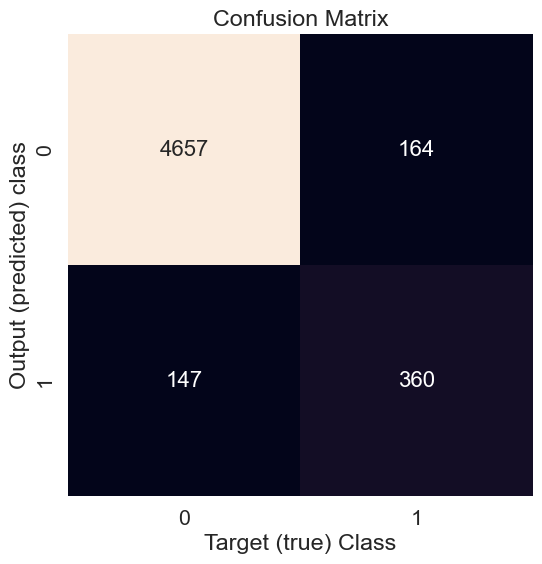

              precision    recall  f1-score   support

       licit       0.97      0.97      0.97      4821
     illicit       0.69      0.71      0.70       507

    accuracy                           0.94      5328
   macro avg       0.83      0.84      0.83      5328
weighted avg       0.94      0.94      0.94      5328

Test data fraud cases, percentage: 9.991924234637692 %


In [187]:
gcn_model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, 'smgcn_best_model.pth.tar'))['state_dict'])
data_train = data.to(Config.device)
y_test_preds = test(gcn_model, data_train)

# confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[split_idx['val']].detach().cpu().numpy(), y_test_preds[split_idx['val']])

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(data_train.y[split_idx['val']].detach().cpu().numpy(),
                            y_test_preds[split_idx['val']],
                            target_names=['licit', 'illicit']))


print(f"Test data fraud cases, percentage: {y_test_preds[split_idx['test']].detach().cpu().numpy().sum() / len(data_train.y[split_idx['test']]) *100} %")